In [2]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import utils
from urllib.request import urlretrieve
import os
from tqdm import tqdm
import zipfile
from collections import Counter
import random

In [3]:
# Path names
dataset_folder_path = 'data'
dataset_filename = 'tex8.zip'
dataset_name = 'Text8 Dataset'

In [4]:
class DLProgress(tqdm):
    last_block = 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
        
if not os.path.isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
                 urlretrieve(url = 'http://mattmahoney.net/dc/text8.zip', 
                             filename = dataset_filename,
                             reporthook = pbar.hook)
            
            
if not os.path.isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open("./data/text8") as f:
    text = f.read()

In [5]:
# Preprocesssing
words = utils.preprocess(text)

In [6]:
words[:25]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes']

In [7]:
print("Total words: ", len(words))
print("Total unique words: ", len(set(words)))

Total words:  16680599
Total unique words:  63641


In [8]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[words] for words in words]

In [9]:
threshold = 1e-5
word_counts = Counter(int_words)
total_counts = len(word_counts)
frequency = {word: count / total_counts for word, count in word_counts.items()}
prob_drop = {word: 1 - np.sqrt(threshold / frequency[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - prob_drop[word])]

In [10]:
len(train_words)

398380

In [26]:
def get_target(words, idx, window_size = 5):
    R = np.random.randint(1, window_size + 1)
    start = idx - R if (idx - R) > 0 else 0
    end = idx + R
    target_words = set(words[start: idx] + words[idx + 1: end + 1])
    return list(target_words)

In [27]:
def get_batches(words, batch_size, window_size = 5):
    n_batches = len(words) // batch_size
    words = words[:n_batches * batch_size]
    
    for i in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[i: i+batch_size]
        for ii in range(len(batch)):
            x_batch = batch[ii]
            y_batch = get_target(batch, ii, window_size)
            x.extend([x_batch] * len(y_batch))
            y.extend(y_batch)
        yield x, y

In [28]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(dtype = tf.int32, shape = [None], name = 'inputs')
    labels = tf.placeholder(dtype = tf.int32, shape = [None, None], name = 'labels')

In [29]:
n_vocabs = len(int_to_vocab)
n_embedding = 200
with train_graph.as_default():
    embedding = tf.random_uniform(shape = (n_vocabs, n_embedding), minval = -1, maxval = 1)
    embed = tf.nn.embedding_lookup(params = embedding, ids = inputs)

In [30]:
n_samples = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal(shape = (n_vocabs, n_embedding), stddev = 0.1))
    softmax_b = tf.Variable(tf.zeros(shape = (n_vocabs)))
    
    loss = tf.nn.sampled_softmax_loss(weights = softmax_w,
                                      biases = softmax_b,
                                      labels = labels,
                                      inputs = embed,
                                      num_sampled = n_samples,
                                      num_classes = n_vocabs)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [31]:
with train_graph.as_default():
    valid_size = 10
    valid_window = 100
    
    valid_examples = np.array(random.sample(population = range(valid_window), k = valid_size // 2))
    
    valid_examples = np.append(arr = valid_examples, 
                               values = np.array(random.sample(population = range(1000, 1000 + valid_window), k = valid_size // 2)))
    
    valid_dataset = tf.constant(value = valid_examples, dtype = tf.int32)
    
    norm = tf.sqrt(tf.reduce_sum(input_tensor = embedding, axis = 1, keepdims = True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarities = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [32]:
!mkdir checkpoints

mkdir: checkpoints: File exists


In [35]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()
    
with tf.Session(graph = train_graph) as sess:
        iteration = 1
        loss = 0
        sess.run(tf.global_variables_initializer())
        
        for e in range(1, epochs + 1):
            batches = get_batches(words = train_words, batch_size = batch_size, window_size = window_size)
            start = time.time()
            
            for x, y in batches:
                feed_dict = {inputs: x, 
                             labels: np.array(y)[:, None]}
                train_loss, _ = sess.run([cost, optimizer], feed_dict = feed_dict)
                
                loss += train_loss
                
                if iteration % 100 == 0:
                    end = time.time()
                    print("Epochs {}/{}, Iteration {}, Loss {}, {:.4f} Sec/Batch".format(e, epochs, iteration, loss / 100, (end-start) / 100))
                    loss = 0
                    start = time.time()
                
                if iteration % 1000 == 0:
                    sim = similarities.eval()
                    for i in range(valid_size):
                        valid_words = int_to_vocab[valid_examples[i]]
                        top_k = 8
                        nearest = (-sim[i, :]).argsort()[1: top_k + 1]
                        log = "nearest to %s:" % valid_words
                        for k in range(top_k):
                            close_words = int_to_vocab[nearest[k]]
                            log = " %s %s" % (log, close_words)
                        print(log)

                iteration += 1
        save_path = saver.save(sess, "./checkpoints/text8.ckpt")
        embed_mat = sess.run(normalized_embedding)

Epochs 1/10, Iteration 100, Loss 5.022564125061035, 0.3057 Sec/Batch
Epochs 1/10, Iteration 200, Loss 5.013615584373474, 0.3001 Sec/Batch
Epochs 1/10, Iteration 300, Loss 5.0044352293014525, 0.2984 Sec/Batch
Epochs 2/10, Iteration 400, Loss 4.965866837501526, 0.0068 Sec/Batch
Epochs 2/10, Iteration 500, Loss 4.929185791015625, 0.3212 Sec/Batch
Epochs 2/10, Iteration 600, Loss 4.981482706069946, 0.3247 Sec/Batch
Epochs 2/10, Iteration 700, Loss 4.975980539321899, 0.3222 Sec/Batch
Epochs 3/10, Iteration 800, Loss 4.937027349472046, 0.0125 Sec/Batch
Epochs 3/10, Iteration 900, Loss 4.960089282989502, 0.3429 Sec/Batch
Epochs 3/10, Iteration 1000, Loss 4.978489298820495, 0.3167 Sec/Batch
        nearest to eight: safl eulemur dicrostonyx kavina griese uranhay wisegirls intersystems
        nearest to states: assembles litter vail forsyth aga ware tudes states
        nearest to is: aga henchman awami headlights schweitzer signaled stork odos
        nearest to use: safl eulemur dicrostonyx 

In [36]:
with train_graph.as_default():
    saver = tf.train.Saver()
    
with tf.Session(graph = train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


In [37]:
%matplotlib inline
%config InlineBacked.figure_format = 'retina'

from sklearn.manifold import TSNE

In [38]:
vis_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[: vis_words, :])

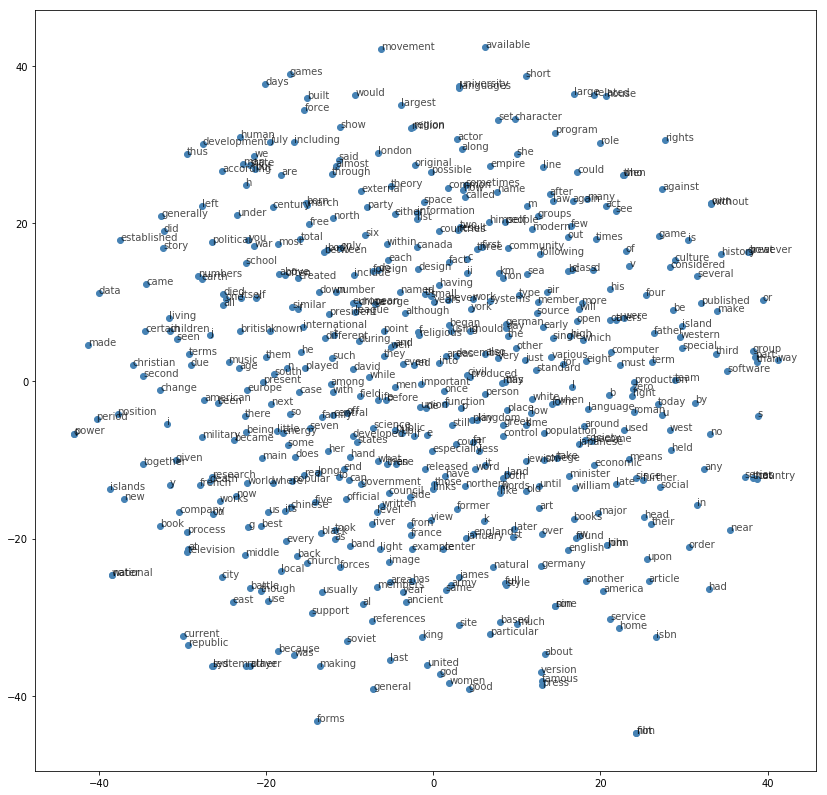

In [44]:
fig, ax = plt.subplots(figsize = (14, 14))
for i in range(vis_words):
    plt.scatter(*embed_tsne[i, :], color = 'steelblue')
    plt.annotate(int_to_vocab[i], (embed_tsne[i, 0], embed_tsne[i, 1]), alpha = 0.7)